# Fake News Diffusion on Social Networks
## Network Science of Socio-Economic Systems

### Learning Objectives
By the end of this tutorial, you will be able to:
1. Load and visualize **diffusion trees** from JSON data
2. Compute key diffusion metrics: **depth**, **size**, **branching factor**
3. Analyze structural differences between **fake** and **real** news spread
4. Study **temporal dynamics** of information cascades
5. Compare diffusion patterns across different news sources

### Research Question

**Do fake and real news spread differently on social media?**

---

## Dataset: FakeNewsNet

**Source**: https://github.com/mdepak/fake-news-propagation/

- **4 categories**: Politifact fake/real, GossipCop fake/real
- **Propagation trees**: How news spreads via Twitter retweets
- **JSON format**: Each file = one news article's diffusion tree

```json
{
  "id": "tweet_id",
  "time": 1623456789,
  "children": [
    {"id": "retweet_1", "time": 1623456880, "children": [...]},
    {"id": "retweet_2", "time": 1623456940, "children": [...]}
  ]
}
```
### GossipCop
**GossipCop** is a fake news dataset focused on **celebrity and entertainment news**, based on fact-checks from Gossip Cop.

### PolitiFact
**PolitiFact** is a misinformation dataset centered on **political claims**, derived from fact-checks by PolitiFact.  


## Step 1: Import Libraries

We'll need:
- **NetworkX**: To build and analyze graph structures
- **NumPy/Pandas**: For numerical analysis and data organization
- **Matplotlib**: For visualizations
- **SciPy**: For statistical tests
- **Collections**: For counting and organizing data

In [18]:
import zipfile
import os

zip_file_path = '/content/nx_network_data.zip'

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('./') # Extract to current directory
    print(f"'{zip_file_path}' extracted successfully.")
else:
    print(f"Error: '{zip_file_path}' not found.")


'/content/nx_network_data.zip' extracted successfully.


In [19]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

### Configure Dataset Paths and Colors

The dataset is organized in 4 folders:
- **politifact_fake**: Fake political news
- **politifact_real**: Real political news  
- **gossipcop_fake**: Fake entertainment news
- **gossipcop_real**: Real entertainment news

We'll use consistent colors throughout:
- Red for fake political news
- Blue for real political news
- Orange for fake entertainment news
- Green for real entertainment news

In [20]:
# Dataset configuration
data_dir = "nx_network_data"  # Main data folder

categories = ['politifact_fake', 'politifact_real', 'gossipcop_fake', 'gossipcop_real']

colors = {
    'politifact_fake': '#E74C3C',    # Red
    'politifact_real': '#3498DB',    # Blue
    'gossipcop_fake': '#E67E22',     # Orange
    'gossipcop_real': '#2ECC71'      # Green
}

print(f"Data directory: {data_dir}")
print(f"Categories: {categories}")

Data directory: nx_network_data
Categories: ['politifact_fake', 'politifact_real', 'gossipcop_fake', 'gossipcop_real']


---
## Step 2: Load One Example Tree

Let's start by loading and visualizing a single diffusion tree to understand the data structure.

**What we'll do:**
1. List all JSON files in the `politifact_fake` folder
2. Load the first file
3. Examine its structure (root tweet and children)

Each JSON file represents how **one news article** spread on Twitter through retweets.

In [21]:
# Load one JSON file from politifact_fake
folder = os.path.join(data_dir, 'politifact_fake')
json_files = [f for f in os.listdir(folder) if f.endswith('.json')]

print(f"Found {len(json_files)} JSON files in {folder}")
print(f"Loading first file: {json_files[0]}")

# Load the JSON
with open(os.path.join(folder, json_files[0]), 'r') as f:
    sample_tree = json.load(f)

print(f"\nRoot tweet ID: {sample_tree['id']}")
print(f"Root timestamp: {sample_tree['time']}")
print(f"Number of direct retweets: {len(sample_tree.get('children', []))}")

Found 351 JSON files in nx_network_data/politifact_fake
Loading first file: politifact14309.json

Root tweet ID: 4983297543
Root timestamp: None
Number of direct retweets: 103


### Build NetworkX Graph from JSON

The JSON tree is **hierarchical** (parent → children), but we need a **graph representation** for analysis.

**Process:**
1. Create an empty directed graph (DiGraph)
2. Recursively traverse the JSON tree
3. Add an edge for each parent-child relationship
4. Store timestamps in a separate dictionary

**Result:** A directed acyclic graph (DAG) where:
- Nodes = tweets/retweets
- Edges = retweet relationships (A → B means B retweeted A)

In [22]:
# Build a directed graph from the JSON tree
G = nx.DiGraph()
times = {}  # Store timestamps

def add_tree_to_graph(node, graph, time_dict):
    """Recursively add nodes and edges from JSON tree."""
    node_id = node['id']
    time_dict[node_id] = node.get('time', None)
    graph.add_node(node_id)

    for child in node.get('children', []):
        child_id = child['id']
        graph.add_edge(node_id, child_id)
        add_tree_to_graph(child, graph, time_dict)

# Build the graph
add_tree_to_graph(sample_tree, G, times)
root_id = sample_tree['id']

print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph built: 137 nodes, 136 edges


### Visualize the Tree

**Visualization details:**
- **Node colors**: Represent depth (distance from root)
  - Darker = closer to root
  - Lighter = further away
- **Root node**: Highlighted in red (original tweet)
- **Edges**: Show retweet direction (who retweeted whom)
- **Layout**: Spring layout spaces nodes based on connections

**Note:** If the tree is very large (>100 nodes), we only show the first 100 for clarity.

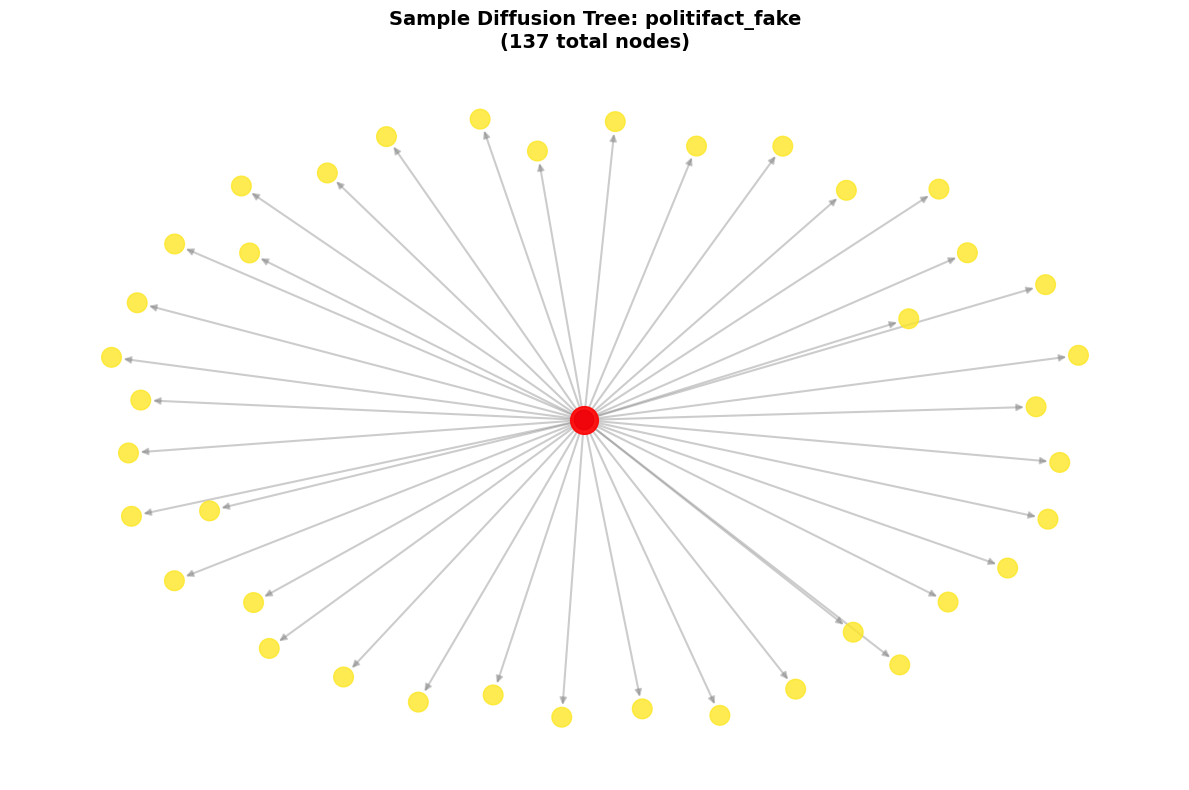

In [23]:
# Visualize (limit to first 100 nodes if tree is large)
if G.number_of_nodes() > 100:
    # Get first 100 nodes by BFS
    bfs_nodes = list(nx.bfs_tree(G, root_id).nodes())[:40]
    G_vis = G.subgraph(bfs_nodes).copy()
else:
    G_vis = G

plt.figure(figsize=(12, 8))

# Use spring layout
pos = nx.spring_layout(G_vis, seed=42, k=1.5)

# Color by depth from root
depths = nx.single_source_shortest_path_length(G_vis, root_id)
node_colors = [depths.get(n, 0) for n in G_vis.nodes()]

# Draw
nx.draw_networkx_nodes(G_vis, pos, node_size=200, node_color=node_colors,
                       cmap='viridis', alpha=0.8)
nx.draw_networkx_edges(G_vis, pos, arrows=True, arrowsize=10,
                       edge_color='gray', alpha=0.4, width=1.5)

# Highlight root in red
nx.draw_networkx_nodes(G_vis, pos, nodelist=[root_id],
                       node_size=400, node_color='red', alpha=0.9)

plt.title(f"Sample Diffusion Tree: politifact_fake\n({G.number_of_nodes()} total nodes)",
         fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

---
## Step 3: Compute Basic Metrics for Sample Tree

Now let's quantify the structure of this diffusion tree.

### Key Metrics:

**1. Tree Size (N)**
- Total number of nodes (retweets + original)
- Measures **virality** - how many people shared the news

**2. Tree Depth (D)**  
- Longest path from root to any leaf
- Measures **cascade length** - how many "hops" the news traveled
- Example: Root → Retweet 1 → Retweet 2 → Retweet 3 = Depth of 3

**3. Branching Factor (B)**
- Average number of children per internal node (nodes that have children)
- Measures **spread pattern**:
  - B ≈ 1: Chain-like (linear spread)
  - B = 2+: Tree-like (potential viral spread)

**4. Maximum Width**
- Largest number of nodes at any single depth level
- Indicates peak simultaneous spread

In [24]:
# Tree size
tree_size = G.number_of_nodes()
print(f"Tree size: {tree_size} nodes")

# Tree depth (longest path from root)
depths = nx.single_source_shortest_path_length(G, root_id)
tree_depth = max(depths.values())
print(f"Tree depth: {tree_depth}")

# Branching factor (average children per node that has children)
out_degrees = [G.out_degree(n) for n in G.nodes() if G.out_degree(n) > 0]
avg_branching = np.mean(out_degrees) if out_degrees else 0
print(f"Average branching factor: {avg_branching:.2f}")

# Width at each level
level_counts = Counter(depths.values())
max_width = max(level_counts.values())
print(f"Maximum width: {max_width} nodes at level {max(level_counts, key=level_counts.get)}")

Tree size: 137 nodes
Tree depth: 4
Average branching factor: 8.50
Maximum width: 103 nodes at level 1


---
## Step 4: Load All Trees and Compute Metrics

Now we'll scale up and analyze **all** diffusion trees in the dataset.

**Process:**
1. Loop through all 4 categories (politifact_fake, politifact_real, gossipcop_fake, gossipcop_real)
2. For each JSON file:
   - Load and build graph
   - Compute metrics (size, depth, branching)
   - Store results
3. Combine everything into a pandas DataFrame

In [25]:
# Store all results
all_results = []

for category in categories:
    folder = os.path.join(data_dir, category)
    json_files = [f for f in os.listdir(folder) if f.endswith('.json')]

    print(f"\nProcessing {category}: {len(json_files)} files")

    for i, filename in enumerate(json_files):
        if (i + 1) % 100 == 0:
            print(f"  ... {i+1}/{len(json_files)}")

        try:
            # Load JSON
            with open(os.path.join(folder, filename), 'r') as f:
                tree_data = json.load(f)

            # Build graph
            G = nx.DiGraph()
            times = {}
            add_tree_to_graph(tree_data, G, times)
            root_id = tree_data['id']

            # Compute metrics
            size = G.number_of_nodes()

            # Depth
            depths = nx.single_source_shortest_path_length(G, root_id)
            depth = max(depths.values())

            # Branching
            out_degrees = [G.out_degree(n) for n in G.nodes() if G.out_degree(n) > 0]
            branching = np.mean(out_degrees) if out_degrees else 0

            # Time duration (if available)
            valid_times = [t for t in times.values() if t is not None]
            if len(valid_times) > 1:
                duration = max(valid_times) - min(valid_times)
            else:
                duration = None

            # Store result
            all_results.append({
                'category': category,
                'filename': filename,
                'size': size,
                'depth': depth,
                'branching': branching,
                'duration': duration
            })

        except Exception as e:
            print(f"  ERROR in {filename}: {e}")

# Create DataFrame
df = pd.DataFrame(all_results)
print(f"\nTotal trees analyzed: {len(df)}")


Processing politifact_fake: 351 files
  ... 100/351
  ... 200/351
  ... 300/351

Processing politifact_real: 277 files
  ... 100/277
  ... 200/277

Processing gossipcop_fake: 3684 files
  ... 100/3684
  ... 200/3684
  ... 300/3684
  ... 400/3684
  ... 500/3684
  ... 600/3684
  ... 700/3684
  ... 800/3684
  ... 900/3684
  ... 1000/3684
  ... 1100/3684
  ... 1200/3684
  ... 1300/3684
  ... 1400/3684
  ... 1500/3684
  ... 1600/3684
  ... 1700/3684
  ... 1800/3684
  ... 1900/3684
  ... 2000/3684
  ... 2100/3684
  ... 2200/3684
  ... 2300/3684
  ... 2400/3684
  ... 2500/3684
  ... 2600/3684
  ... 2700/3684
  ... 2800/3684
  ... 2900/3684
  ... 3000/3684
  ... 3100/3684
  ... 3200/3684
  ... 3300/3684
  ... 3400/3684
  ... 3500/3684
  ... 3600/3684

Processing gossipcop_real: 6945 files
  ... 100/6945
  ... 200/6945
  ... 300/6945
  ... 400/6945
  ... 500/6945
  ... 600/6945
  ... 700/6945
  ... 800/6945
  ... 900/6945
  ... 1000/6945
  ... 1100/6945
  ... 1200/6945
  ... 1300/6945
  ... 14

### Summary Statistics by Category

Let's aggregate the metrics to see overall patterns:

**What to look for:**
- **Count**: How many trees in each category
- **Mean vs Median**: Large difference suggests heavy-tailed distribution (few very large cascades)
- **Standard deviation**: High values indicate high variability
- **Fake vs Real**: Do fake news cascades tend to be larger/deeper/more branched?
- **Politifact vs GossipCop**: Different spreading patterns in political vs entertainment news?

In [26]:
# Summary statistics by category
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

summary = df.groupby('category').agg({
    'size': ['count', 'mean', 'median', 'std'],
    'depth': ['mean', 'median', 'std'],
    'branching': ['mean', 'std']
}).round(2)

print(summary)


SUMMARY STATISTICS
                 size                          depth              branching  \
                count     mean median      std  mean median   std      mean   
category                                                                      
gossipcop_fake   3684   322.34   31.0   744.41  3.24    2.0  2.01      7.86   
gossipcop_real   6945   118.89   74.0   219.84  2.68    2.0  1.12     22.60   
politifact_fake   351   809.48  240.0  2388.83  5.03    5.0  2.19      7.16   
politifact_real   277  1517.05  185.0  3939.14  4.78    5.0  2.27      7.61   

                        
                   std  
category                
gossipcop_fake    8.43  
gossipcop_real   13.55  
politifact_fake   4.89  
politifact_real   5.97  


---
## Step 5: Tree Size Distribution

Let's visualize how cascade sizes are distributed.

### Why Log-Log Plots?

Social phenomena often follow **power-law** or **heavy-tailed** distributions:
- Most cascades are small (few retweets)
- A few cascades are very large (viral)
- This spans many orders of magnitude

**Log-log plots** make these patterns visible:
- X-axis: Tree size (log scale)
- Y-axis: Probability (log scale)
- Power law appears as a straight line

### What to Look For:

1. **Shape of distribution**:
   - Straight line on log-log = power law
   - Curved = other distribution (exponential, log-normal)

2. **Differences between fake/real**:
   - Does one curve lie above the other?
   - Do fake news have more large cascades?

3. **Heavy tail**:
   - Do we see cascades with 1000+ nodes?
   - How common are viral cascades?

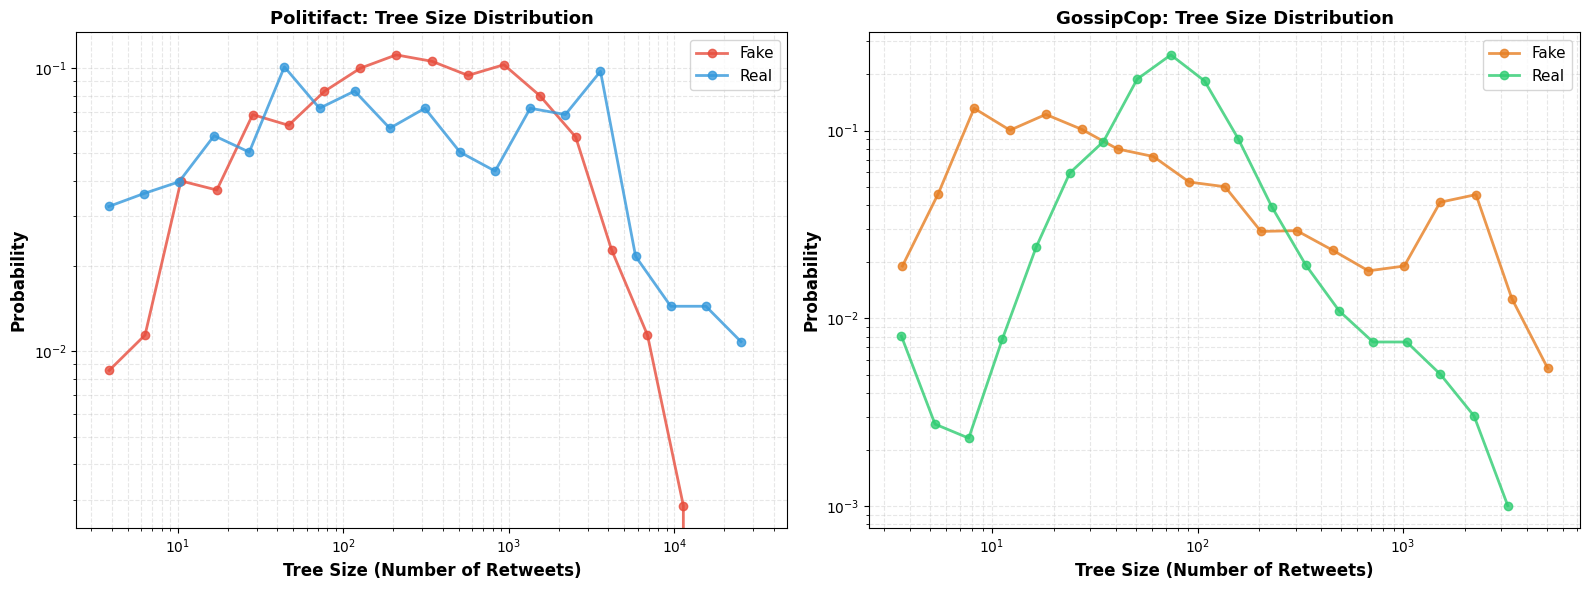

In [27]:
# Create log-binned histograms
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Politifact
for cat in ['politifact_fake', 'politifact_real']:
    sizes = df[df['category'] == cat]['size'].values
    sizes = sizes[sizes > 0]  # Remove zeros

    # Log-spaced bins
    bins = np.logspace(np.log10(sizes.min()), np.log10(sizes.max()), 20)
    hist, bin_edges = np.histogram(sizes, bins=bins, density=True)
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

    # Normalize to probability
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    hist = hist * bin_widths

    label = 'Fake' if 'fake' in cat else 'Real'
    axes[0].loglog(bin_centers, hist, 'o-', label=label, color=colors[cat],
                   linewidth=2, markersize=6, alpha=0.8)

axes[0].set_xlabel('Tree Size (Number of Retweets)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Probability', fontsize=12, fontweight='bold')
axes[0].set_title('Politifact: Tree Size Distribution', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, which='both', alpha=0.3, linestyle='--')

# GossipCop
for cat in ['gossipcop_fake', 'gossipcop_real']:
    sizes = df[df['category'] == cat]['size'].values
    sizes = sizes[sizes > 0]

    bins = np.logspace(np.log10(sizes.min()), np.log10(sizes.max()), 20)
    hist, bin_edges = np.histogram(sizes, bins=bins, density=True)
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    hist = hist * bin_widths

    label = 'Fake' if 'fake' in cat else 'Real'
    axes[1].loglog(bin_centers, hist, 'o-', label=label, color=colors[cat],
                   linewidth=2, markersize=6, alpha=0.8)

axes[1].set_xlabel('Tree Size (Number of Retweets)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Probability', fontsize=12, fontweight='bold')
axes[1].set_title('GossipCop: Tree Size Distribution', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, which='both', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('retweets_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Statistical Test: Size Differences

Visual inspection is good, but we need **statistical tests** to confirm differences.

**Mann-Whitney U Test:**
- **Non-parametric** test (doesn't assume normal distribution)
- Perfect for heavy-tailed data like ours
- Tests if two samples come from the same distribution
- Null hypothesis: Fake and real news have the same size distribution

**Interpreting p-values:**
- p < 0.01: **Very significant** - reject null hypothesis with 99% confidence
- p < 0.05: **Significant** - reject null hypothesis with 95% confidence  
- p ≥ 0.05: **Not significant** - cannot reject null hypothesis

**Median vs Mean:**
- We report both because distributions are skewed
- Median = typical value (50th percentile)
- Mean = average (pulled up by large outliers)

In [28]:
# Mann-Whitney U test (non-parametric)
print("\n" + "="*60)
print("STATISTICAL TESTS: Tree Size")
print("="*60)

# Politifact
pf_fake = df[df['category'] == 'politifact_fake']['size'].values
pf_real = df[df['category'] == 'politifact_real']['size'].values
statistic, pvalue = stats.mannwhitneyu(pf_fake, pf_real)

print(f"\nPolitifact:")
print(f"  Fake:  Median={np.median(pf_fake):.0f}, Mean={np.mean(pf_fake):.1f}")
print(f"  Real:  Median={np.median(pf_real):.0f}, Mean={np.mean(pf_real):.1f}")
print(f"  Mann-Whitney U: p-value={pvalue:.4f}")
if pvalue < 0.01:
    print(f"  → Significant difference (p < 0.01)")
else:
    print(f"  → No significant difference")

# GossipCop
gc_fake = df[df['category'] == 'gossipcop_fake']['size'].values
gc_real = df[df['category'] == 'gossipcop_real']['size'].values
statistic, pvalue = stats.mannwhitneyu(gc_fake, gc_real)

print(f"\nGossipCop:")
print(f"  Fake:  Median={np.median(gc_fake):.0f}, Mean={np.mean(gc_fake):.1f}")
print(f"  Real:  Median={np.median(gc_real):.0f}, Mean={np.mean(gc_real):.1f}")
print(f"  Mann-Whitney U: p-value={pvalue:.4f}")
if pvalue < 0.01:
    print(f"  → Significant difference (p < 0.01)")
else:
    print(f"  → No significant difference")


STATISTICAL TESTS: Tree Size

Politifact:
  Fake:  Median=240, Mean=809.5
  Real:  Median=185, Mean=1517.0
  Mann-Whitney U: p-value=0.6719
  → No significant difference

GossipCop:
  Fake:  Median=31, Mean=322.3
  Real:  Median=74, Mean=118.9
  Mann-Whitney U: p-value=0.0000
  → Significant difference (p < 0.01)


---
## Step 6: Depth Distribution

How deep do retweet cascades go?

**Depth** = longest chain from original tweet to final retweet

### Examples:
- **Depth 1**: Only direct retweets of original (no retweets of retweets)
- **Depth 2**: Original → Retweet → Retweet of retweet
- **Depth 5**: Chain of 5 retweets

### What to Expect:

Most cascades are **shallow** (depth 2-5) because:
1. People mostly retweet the original post
2. Retweets of retweets are less common
3. Long chains decay quickly

**Question**: Do fake news create deeper cascades than real news?

### Visualization:
- Semi-log plot (linear x-axis, log y-axis)
- Shows exponential decay of deep cascades
- Most probability mass at low depths

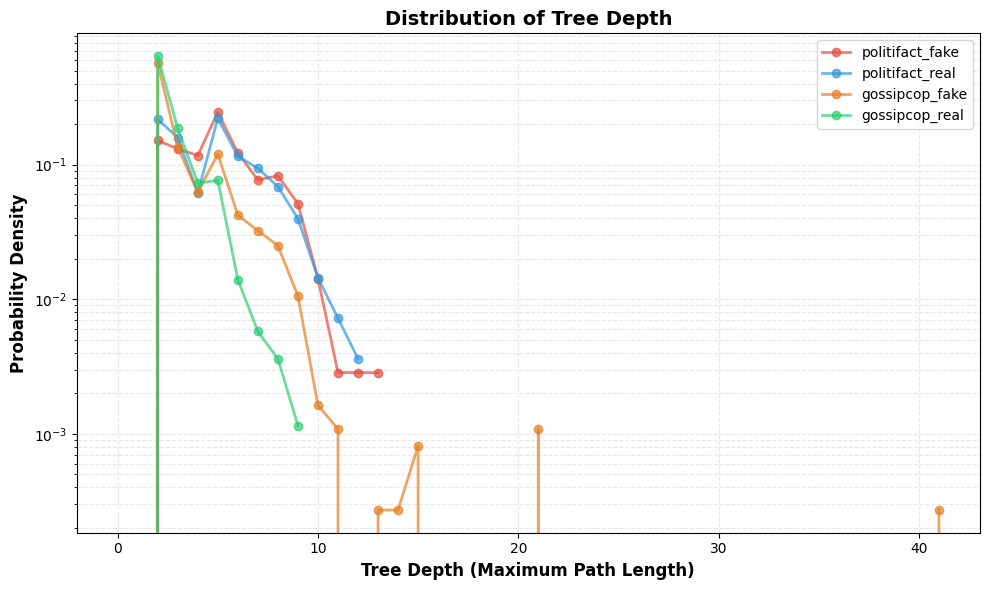

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

for cat in categories:
    depths = df[df['category'] == cat]['depth'].values

    # Integer bins
    max_depth = int(depths.max())
    bins = np.arange(0, max_depth + 2) - 0.5

    hist, bin_edges = np.histogram(depths, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    ax.plot(bin_centers, hist, 'o-', label=cat, color=colors[cat],
           linewidth=2, markersize=6, alpha=0.7)

ax.set_xlabel('Tree Depth (Maximum Path Length)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Tree Depth', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, which='both', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('depth.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Step 7: Branching Factor Distribution

How many retweets does each tweet generate?

**Branching Factor** = average number of children per internal node (nodes that have at least one child)

### Interpretation:

**Low branching (1-2)**:
- Chain-like spread
- Each person retweets to ~1 other person
- Linear propagation

**Medium branching (3-6)**:
- Tree-like spread  
- Balanced viral growth
- Typical of organic sharing

**High branching (10+)**:
- Star-like broadcast
- One influential node reaches many
- Celebrity/bot behavior

### Research Questions:
1. Do fake news have higher branching (more viral)?
2. Are there "super-spreader" nodes with very high branching?
3. Does branching differ between political and entertainment news?

**Note**: We use log-log scale because branching factor can vary widely (1 to 100+)

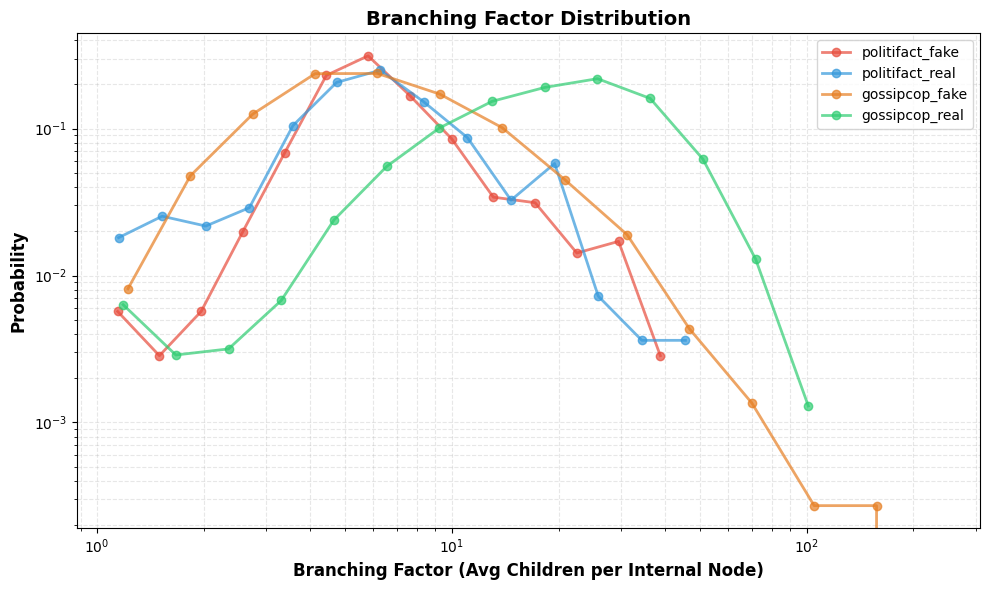

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

for cat in categories:
    branching = df[df['category'] == cat]['branching'].values
    branching = branching[branching > 0]  # Remove zeros

    if len(branching) > 0:
        # Log bins
        bins = np.logspace(np.log10(branching.min()), np.log10(branching.max()), 15)
        hist, bin_edges = np.histogram(branching, bins=bins, density=True)
        bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
        bin_widths = bin_edges[1:] - bin_edges[:-1]
        hist = hist * bin_widths

        ax.loglog(bin_centers, hist, 'o-', label=cat, color=colors[cat],
                 linewidth=2, markersize=6, alpha=0.7)

ax.set_xlabel('Branching Factor (Avg Children per Internal Node)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability', fontsize=12, fontweight='bold')
ax.set_title('Branching Factor Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, which='both', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('branching_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Step 8: Temporal Analysis - Diffusion Speed

How quickly do cascades grow over time?

### The Challenge:

Different cascades have different:
- **Total sizes** (10 nodes vs 10,000 nodes)
- **Durations** (1 hour vs 1 month)

We can't compare them directly!

### Our Solution: Normalization

For each cascade:
1. **Time normalization**: Scale time to [0, 1]
   - 0 = first tweet
   - 1 = last tweet
   - 0.5 = halfway through cascade

2. **Size normalization**: Count fraction of total adopters
   - 0 = no one yet
   - 1 = everyone who will adopt
   - 0.5 = half of eventual adopters

3. **Aggregation**: Average across all cascades

### Result: Cumulative Adoption Curve

Shows typical growth pattern:
- **S-shaped**: Slow start, rapid growth, plateau
- **Exponential**: Rapid early growth
- **Linear**: Steady growth throughout

**Research question**: Do fake news spread faster than real news?


In [31]:
# Collect normalized diffusion curves for each category
diffusion_curves = {cat: [] for cat in categories}

for cat in categories:
    folder = os.path.join(data_dir, cat)
    json_files = [f for f in os.listdir(folder) if f.endswith('.json')]

    print(f"Processing {cat} for diffusion speed...")

    for filename in json_files:  # Limit to first 200 for speed
        try:
            # Load and build graph
            with open(os.path.join(folder, filename), 'r') as f:
                tree_data = json.load(f)

            G = nx.DiGraph()
            times = {}
            add_tree_to_graph(tree_data, G, times)
            root_id = tree_data['id']

            # Get valid timestamps
            valid_times = [(nid, t) for nid, t in times.items() if t is not None]

            if len(valid_times) < 2:
                continue

            # Get root time
            root_time = times.get(root_id)
            if root_time is None:
                root_time = min(t for _, t in valid_times)

            # Relative times
            rel_times = [max(0, t - root_time) for _, t in valid_times]

            if max(rel_times) == 0:
                continue

            # Normalize to [0, 1]
            max_time = max(rel_times)
            norm_times = [t / max_time for t in rel_times]
            norm_times.sort()

            # Cumulative count
            cumulative = np.arange(1, len(norm_times) + 1) / len(norm_times)

            diffusion_curves[cat].append((norm_times, cumulative))

        except Exception as e:
            pass

    print(f"  Collected {len(diffusion_curves[cat])} curves")

Processing politifact_fake for diffusion speed...
  Collected 351 curves
Processing politifact_real for diffusion speed...
  Collected 277 curves
Processing gossipcop_fake for diffusion speed...
  Collected 3684 curves
Processing gossipcop_real for diffusion speed...
  Collected 6945 curves


### Aggregate Diffusion Curves

Now we need to combine hundreds of curves into one average curve per category.

**Problem**: Each curve has different time points (some have 10 nodes, others 1000)

**Solution - Interpolation**:
1. Create a common time grid (50 equally-spaced points from 0 to 1)
2. For each curve, interpolate values at these 50 points
3. Average all interpolated curves
4. Compute standard deviation (for error bars)

**Output**:
- Mean curve showing typical behavior
- Standard deviation showing variability

In [32]:
# Aggregate curves
time_grid = np.linspace(0, 1, 50)
aggregated = {}

for cat in categories:
    if len(diffusion_curves[cat]) == 0:
        continue

    # Interpolate all curves onto common grid
    interpolated = []
    for times, cumul in diffusion_curves[cat]:
        interp = np.interp(time_grid, times, cumul)
        interpolated.append(interp)

    interpolated = np.array(interpolated)
    mean_curve = interpolated.mean(axis=0)
    std_curve = interpolated.std(axis=0)

    aggregated[cat] = (mean_curve, std_curve)

print("Aggregation complete.")

Aggregation complete.


### Plot Diffusion Speed

This plot shows the **cumulative adoption curve** for each category.

**How to read it:**
- **X-axis**: Normalized time (0 = start, 1 = end of cascade)
- **Y-axis**: Fraction of total adopters reached (0 = none, 1 = all)
- **Solid line**: Average behavior across all cascades
- **Shaded area**: ±1 standard deviation (variability)


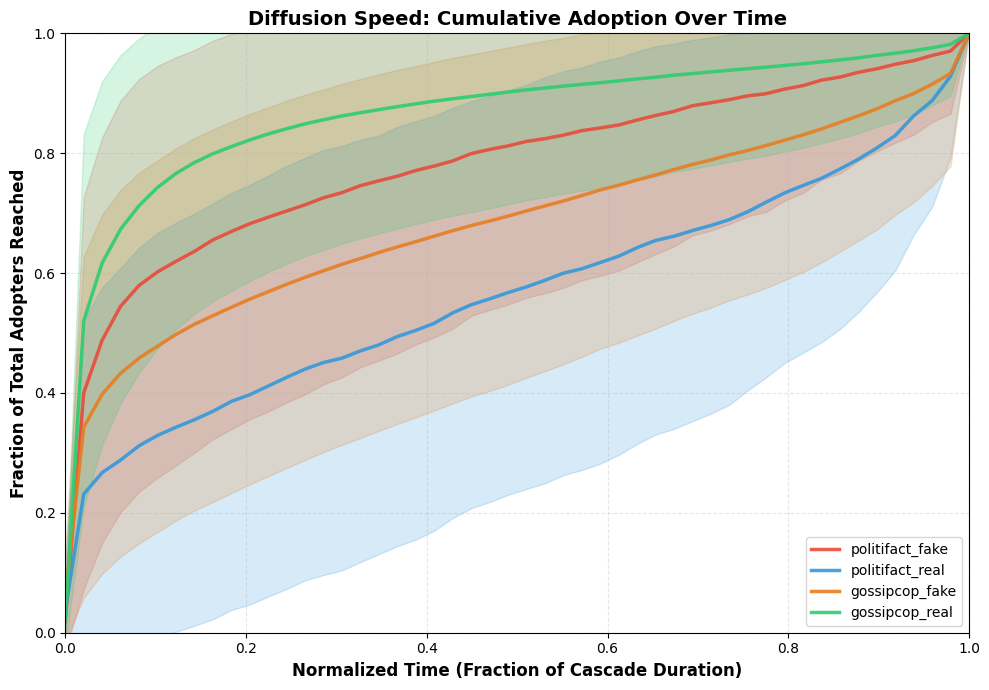

In [33]:
# Plot diffusion speed
fig, ax = plt.subplots(figsize=(10, 7))

for cat in categories:
    if cat in aggregated:
        mean_curve, std_curve = aggregated[cat]

        # Plot mean
        ax.plot(time_grid, mean_curve, '-', label=cat, color=colors[cat],
               linewidth=2.5, alpha=0.9)

        # Plot confidence interval
        ax.fill_between(time_grid,
                        mean_curve - std_curve,
                        mean_curve + std_curve,
                        color=colors[cat], alpha=0.2)

ax.set_xlabel('Normalized Time (Fraction of Cascade Duration)', fontsize=12, fontweight='bold')
ax.set_ylabel('Fraction of Total Adopters Reached', fontsize=12, fontweight='bold')
ax.set_title('Diffusion Speed: Cumulative Adoption Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('diffusion_speed.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Step 9: Summary Statistics Table

Let's create a final summary table comparing all four categories side-by-side.

**This table shows:**
- **N Trees**: Dataset size for each category
- **Size metrics**: Median and mean cascade size
- **Depth metrics**: Median and mean cascade depth
- **Branching**: Average branching factor

**Use this to:**
1. Compare fake vs real within each source
2. Compare Politifact vs GossipCop
3. Identify which metrics differ most
4. Support conclusions about fake news spreading patterns

In [34]:
# Create comprehensive summary
summary_rows = []

for cat in categories:
    cat_df = df[df['category'] == cat]

    row = {
        'Category': cat,
        'N Trees': len(cat_df),
        'Size (Median)': cat_df['size'].median(),
        'Size (Mean)': cat_df['size'].mean(),
        'Depth (Median)': cat_df['depth'].median(),
        'Depth (Mean)': cat_df['depth'].mean(),
        'Branching (Mean)': cat_df['branching'].mean()
    }
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)

print("\n" + "="*90)
print("SUMMARY STATISTICS")
print("="*90)
print(summary_df.to_string(index=False, float_format='%.2f'))
print("="*90)


SUMMARY STATISTICS
       Category  N Trees  Size (Median)  Size (Mean)  Depth (Median)  Depth (Mean)  Branching (Mean)
politifact_fake      351         240.00       809.48            5.00          5.03              7.16
politifact_real      277         185.00      1517.05            5.00          4.78              7.61
 gossipcop_fake     3684          31.00       322.34            2.00          3.24              7.86
 gossipcop_real     6945          74.00       118.89            2.00          2.68             22.60
